In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

import time

from joblib import Parallel, delayed, cpu_count
from matplotlib import cm

# Methods

In [2]:
def inner_solver(x, y, z, gamma1, gamma2, eta, rho, epsilon, maxiter):
    j = 0
    norm_grad = np.Inf
    w = y
    lamb = 0

    while norm_grad > epsilon:

        # obtain gradient of G and H
        _, _, d2g = oracle_G(x, w)
        h, _, d2h = oracle_H(x, w)

        # compute the gradient of augmented Lagrangian
        grad_w = d2g + 1 /  gamma1 * np.maximum(0, gamma1 * lamb + h) * d2h
        grad_lamb = np.maximum(-gamma1 * lamb, h) - gamma2 * (lamb - z)
        # print(d2g, h, d2h, grad_w, grad_lamb)

        # update the variables by gradient descent ascent
        stepsz_w = eta 
        stepsz_lamb = rho 
        # stepsz_w = eta / (j + 1)
        # stepsz_lamb = rho / (j + 1)
        w = w - stepsz_w * grad_w
        w = ProjY(w)
        lamb = lamb + stepsz_lamb * grad_lamb

        # project the variables to the feasible set
        lamb = np.maximum(lamb, 0)

        # compute the norm of the gradient
        norm_grad = np.sqrt(np.linalg.norm(grad_w)**2 + np.linalg.norm(grad_lamb)**2)

        # compute the regularized augmented Lagrangian
        # AL = G(x, y) + 0.5 / gamma1 * np.sum(np.maximum(0, gamma1 * lamb + h)**2 - gamma1 ** 2 * lamb **2) - 0.5 * gamma2 * (lamb - z)**2

        # print('iter: %d, norm_grad: %f, AL: %f' % (j, norm_grad, AL))
        # print('iter: %d, x: %f, w: %f, lamb: %f, norm_grad: %f' % (j, x, w, lamb, norm_grad))

        j += 1
        if j > maxiter:
            break
    return j, w, lamb

In [3]:


def outer_solver(x0, y0, alpha, c1, c2, r, t, gamma1, gamma2, eta, rho, epsilon, maxiter, inner_maxiter):
    k = 0
    total_complexity = 0
    x = x0
    y = y0
    z = 0
    norm_grad = np.Inf
    hist = []
    while norm_grad > epsilon:
        s, w, lamb = inner_solver(x, y, z, gamma1, gamma2, eta, rho, epsilon, inner_maxiter)
        total_complexity += s
        d1f_list = []

        for l in range(r):
            _, d1f, d2f = oracle_F(x, y)
            d1f_list.append(d1f)
        d1f = np.mean(d1f_list)
        total_complexity += r

        d1mathcalG_list = []
        d2g_list = []
        for l in range(t):
            # print('w', w, 'x', x, 'lambda', lamb)
            _, d1g, d2g = oracle_G(x, y)
            _, d1g_, _  = oracle_G(x, w)
            h, d1h, _ = oracle_H(x, w)
            # print('d1g', d1g, 'd1g_', d1g_, 'd1h', d1h)
            d2g_list.append(d2g)
            d1mathcalG_list.append(d1g - d1g_ -  1 /  gamma1 * np.maximum(0, gamma1 * lamb + h) * d1h)
        d2g = np.mean(d2g_list)
        d1mathcalG = np.mean(d1mathcalG_list)
        total_complexity += 2 * t

        h, d1h, d2h = oracle_H(x, y)
        grad_x = d1f + c1 * d1mathcalG + c2 * np.maximum(h, 0) * d1h
        grad_y = d2f + c1 * d2g + c2 * np.maximum(h, 0) * d2h
        # grad_x = d1f + c * d1mathcalG + c * np.maximum(h, 0) * d1h
        # grad_y = d2f + c * d2g + c * np.maximum(h, 0) * d2h
        grad_z =  gamma2 * (lamb - z)

        # print(c * d2g, c2 * np.maximum(h, 0) * d2h)

        # print(d1f, d1mathcalG)
        # print(grad_x, grad_y, grad_z)
        stepsz = alpha
        x = x - stepsz  * grad_x
        x = ProjX(x)
        y = y - stepsz  * grad_y
        y = ProjY(y)
        z = z - stepsz * grad_z
        z = np.maximum(z, 0)
        norm_grad = np.sqrt(np.linalg.norm(grad_x)**2 + np.linalg.norm(grad_y)**2 + np.linalg.norm(grad_z)**2)

        k += 1
        hist.append([x, y])
        if k >= maxiter:
            break
        x_avg = np.mean([x for x, _ in hist])
        y_avg = np.mean([y for _, y in hist])
        
        # choose random index from 0 to k-1
        R = np.random.randint(0, k)
        x_rand, y_rand = hist[R]

        x = x_avg
        _, y, _ = inner_solver(x, y, 0, gamma1, 0, eta, rho, epsilon, 1000)

    return k, x, y, total_complexity, hist
    # return k, x_rand, y_rand, total_complexity, hist

# Toy example 1

In [4]:
sigma_default = 0.1
a = 6
def F(x,y):
    return np.exp(-y+2)/(2+np.cos(a*x))+0.5*np.log((4*x-2)**2+1) + x**2

def d1f(x, y, sigma=sigma_default):
    return a*math.exp(-y+2)*math.sin(a*x)/((2+math.cos(4*x))**2)+(16*x-8)/((4*x-2)**2+1) + 2*x + np.random.normal(0, sigma)

def d2f(x, y, sigma=sigma_default):
    return -math.exp(-y+2)/(2+math.cos(a*x)) + np.random.normal(0, sigma)

def df(x, y, sigma=sigma_default):
    return np.array([d1f(x, y, sigma), d2f(x, y, sigma)])

def oracle_F(x, y, sigma=sigma_default):
    return F(x, y), d2f(x, y, sigma), d2f(x, y, sigma)

def G(x, y):
    return (y-2*x)**2

def d1g(x, y, sigma=sigma_default):
    return -4*(y-2*x) + np.random.normal(0, sigma)

def d2g(x, y, sigma=sigma_default):
    return 2*(y-2*x) + np.random.normal(0, sigma)

def dg(x, y, sigma=sigma_default):
    return np.array([d1g(x, y ,sigma), d2g(x, y, sigma)])

def oracle_G(x, y, sigma=sigma_default):
    return G(x, y), d1g(x, y, sigma), d2g(x, y, sigma)

def H(x, y):
    return y - x

def d1H(x, y):
    return -1

def d2H(x, y):
    return 1

def dH(x, y):
    return np.array([d1H(x, y), d2H(x, y)])

def oracle_H(x, y):
    return H(x, y), d1H(x, y), d2H(x, y)

def ProjX(x):
    return np.maximum(0, np.minimum(3, x))

def ProjY(y):
    return np.maximum(0, np.minimum(3, y))


In [5]:


alpha = 0.005 # step size of the outer loop
c1 = 30 # penalty parameter
c2 = 15
r = 5 # number of samples for the gradient of F
t = 1 # number of samples for the gradient of mathcalG
gamma1 = 10 # penalty parameter for the augmented Lagrangian
gamma2 = 0.1 # penalty parameter for the Moreau-Yosida regularization
eta = 0.1 # primal step size of the inner loop
rho = 0.1 # dual step size of the inner loop
epsilon = 0.01 # tolerance of the norm of the gradient
maxiter = 500 # maximum number of iterations
inner_maxiter = 10 # maximum number of iterations in the inner loop

N_exp = 200
xs = []
ys = []
for e in range(N_exp):
    x0 = np.random.uniform(0, 3)
    y0 = np.random.uniform(0, 3)
    K, x, y, total_complexity, hist = outer_solver(x0, y0, alpha, c1, c2, r, t, gamma1, gamma2, eta, rho, epsilon, maxiter, inner_maxiter)
    xs.append(x)
    ys.append(y)
    print('K: %d, x: %f, y: %f, total_complexity: %d' % (K, x, y, total_complexity))

K: 500, x: 0.017622, y: 0.053533, total_complexity: 8531
K: 500, x: 0.099118, y: 0.232285, total_complexity: 9000
K: 500, x: 0.084076, y: 0.096288, total_complexity: 8960
K: 500, x: 0.056788, y: 0.053344, total_complexity: 8483
K: 500, x: 0.050456, y: 0.100329, total_complexity: 8713
K: 500, x: 0.049573, y: 0.131817, total_complexity: 8961
K: 500, x: 0.082018, y: 0.052334, total_complexity: 8463
K: 500, x: 0.056749, y: 0.084762, total_complexity: 8860
K: 500, x: 0.008870, y: 0.037358, total_complexity: 8558
K: 500, x: 0.046472, y: 0.121094, total_complexity: 8892
K: 500, x: 0.065781, y: 0.140594, total_complexity: 8970
K: 500, x: 0.060044, y: 0.095831, total_complexity: 8923
K: 500, x: 0.051086, y: 0.057302, total_complexity: 8546
K: 500, x: 0.019739, y: 0.055560, total_complexity: 8402


KeyboardInterrupt: 

(array([ 2.,  4.,  6.,  8., 10., 12.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

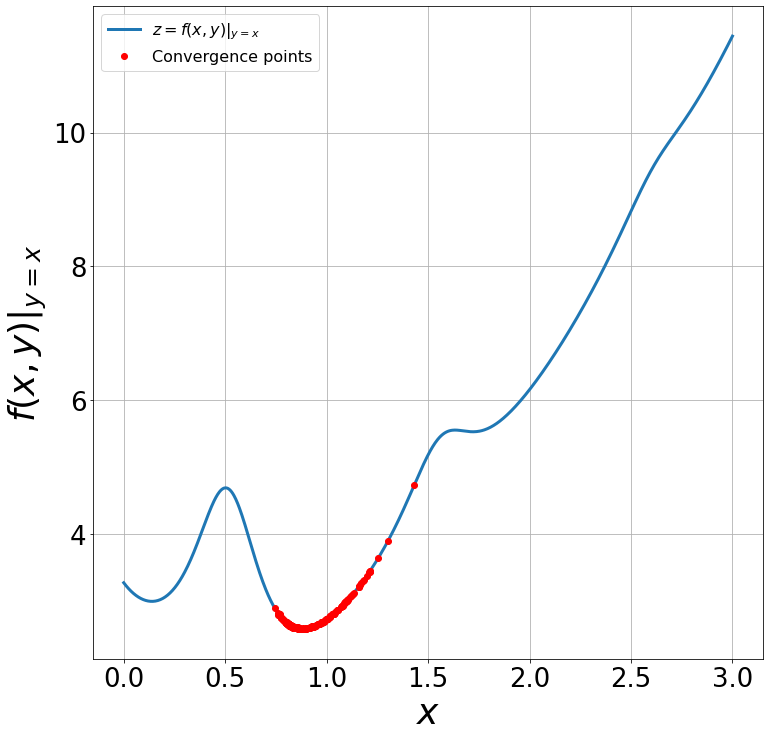

In [8]:
x_ax = np.linspace(0, 3, 1000)

plt.figure(figsize=(12, 12))
plt.plot(x_ax, F(x_ax,x_ax), linewidth=3)
for e in  range(N_exp):
    x = xs[e]
    y = ys[e]
    plt.plot(x, F(x, y), 'o', color='r')

plt.legend(['$z=f(x,y)|_{y=x}$', 'Convergence points'], fontsize=16)
plt.grid()
plt.xlabel('$x$', fontsize=36)
plt.ylabel('$f(x,y)|_{y=x}$', fontsize=36)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)

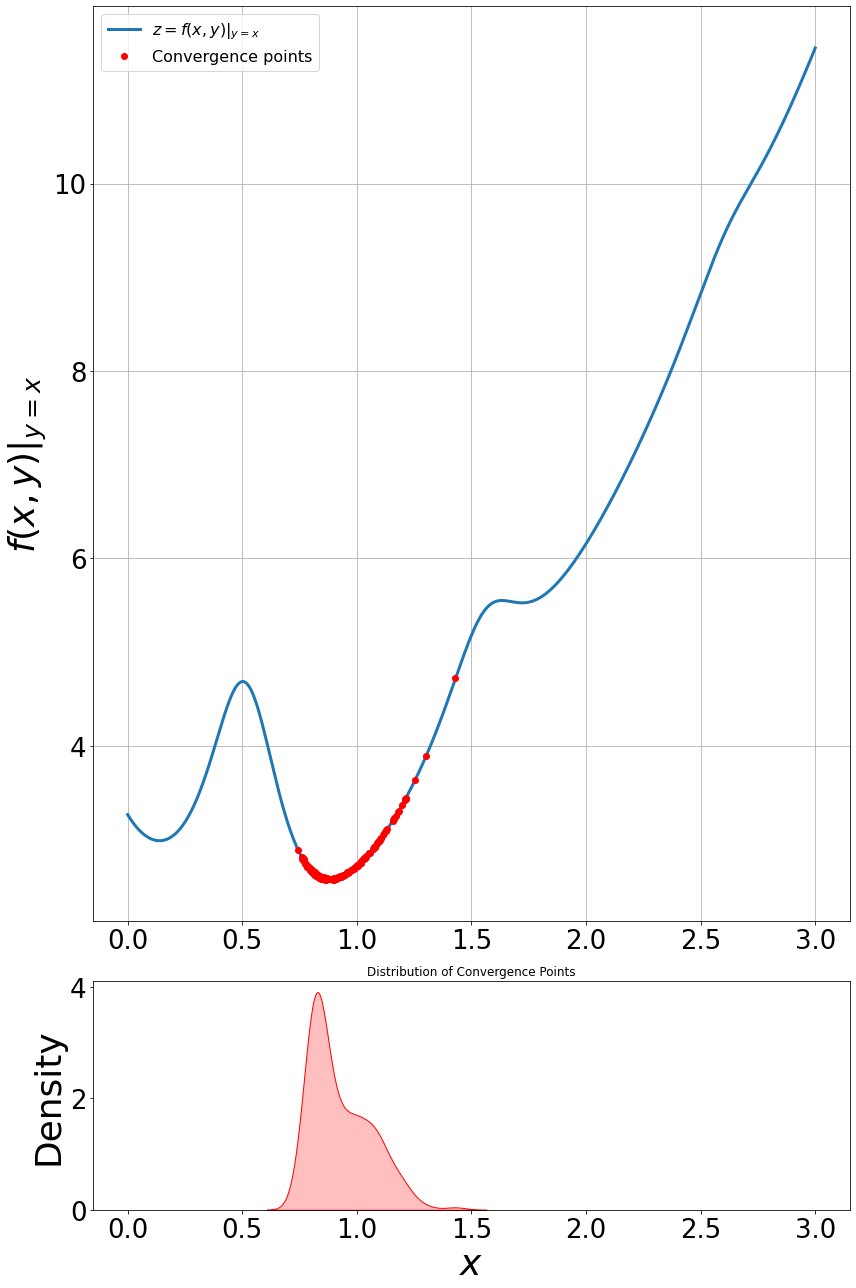

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec

# Assuming xs, ys are your arrays containing the 1000 points
x_ax = np.linspace(0, 3, 1000)

# Create a figure with gridspec
fig = plt.figure(figsize=(12, 18))

# Create a GridSpec with custom height ratios
gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1])  # First subplot taller, second subplot compressed

# First plot (function and convergence points)
ax0 = fig.add_subplot(gs[0])
ax0.plot(x_ax, F(x_ax, x_ax), linewidth=3)

for e in range(N_exp):
    x = xs[e]
    y = ys[e]
    ax0.plot(x, F(x, y), 'o', color='r')

ax0.legend(['$z=f(x,y)|_{y=x}$', 'Convergence points'], fontsize=16)
ax0.grid()
ax0.set_ylabel('$f(x,y)|_{y=x}$', fontsize=36)
ax0.tick_params(axis='both', labelsize=26)

# Second plot (KDE plot of function values at convergence points, normalized to [0, 1])
ax1 = fig.add_subplot(gs[1], sharex=ax0)  # Share x-axis with ax0
sns.kdeplot(xs, ax=ax1, shade=True, common_norm=True, color='r')
ax1.set_title('Distribution of Convergence Points')
ax1.set_xlabel('$x$', fontsize=36)
ax1.set_ylabel('Density', fontsize=36)
ax1.tick_params(axis='both', labelsize=26)

plt.tight_layout()
plt.show()


Text(0.5, 0.5, '$x$')

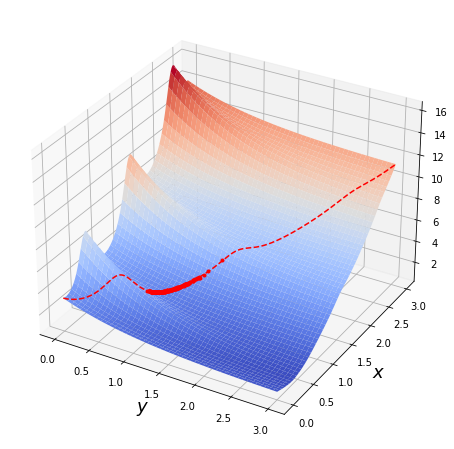

In [11]:
Xx = np.linspace(0,3,1000)
Yy = np.linspace(0,3,1000)
X, Y = np.meshgrid(Xx, Yy)

Z = F(X, Y) # + 0.5 * 1 * np.maximum(0, H(X, Y))**2

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(12,8))
surf = ax.plot_surface(Y,X, Z, cmap=cm.coolwarm, alpha=1.)#, rstride=1, cstride=1)

ax.plot(Xx, Xx, F(Xx, Xx), 'r--', zorder=10)
for e in  range(N_exp):
    x = xs[e]
    y = ys[e]
    ax.plot(y, x, F(x, y), 'o', color='r', zorder=10, markersize=3)

ax.set_xlabel("$y$", fontsize=18)
ax.set_ylabel("$x$", fontsize=18)

Text(0.5, 0.5, '$x$')

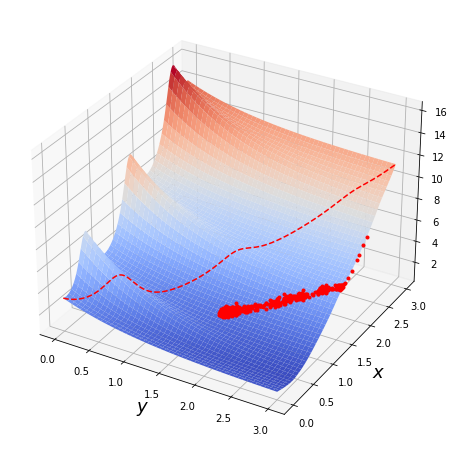

In [12]:
Xx = np.linspace(0,3,1000)
Yy = np.linspace(0,3,1000)
X, Y = np.meshgrid(Xx, Yy)

Z = F(X, Y) # + 0.5 * 1 * np.maximum(0, H(X, Y))**2

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(12,8))
surf = ax.plot_surface(Y,X, Z, cmap=cm.coolwarm, alpha=1.)#, rstride=1, cstride=1)

ax.plot(Xx, Xx, F(Xx, Xx), 'r--', zorder=10)

for i in range(K):
    x = hist[i][0]
    y = hist[i][1]
    ax.plot(y, x, F(x, y), 'o', color='r', zorder=10, markersize=3)
    
ax.set_xlabel("$y$", fontsize=18)
ax.set_ylabel("$x$", fontsize=18)